In [45]:
import matplotlib
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from dateutil.parser import parse
from datetime import timedelta

In [46]:
results_dir = "results/delay"

results = []
for d in os.listdir(results_dir):
    if d.startswith("image"):
        for f in os.listdir(f"{results_dir}/{d}"):
            if f.endswith("json") and f.startswith("PodStartupLatency"):
                results.append((f"{d}/{f}", f"{d}/config.json"))

df = pd.DataFrame()
for (r, config) in results:
    with open(f"{results_dir}/{config}", "r") as c:
        with open(f"{results_dir}/{r}") as r:
            
            config_json = json.loads(c.read())
            results_json = json.loads(r.read())
            
            rows_json = defaultdict(list)

            for item in results_json["dataItems"]:
                name = item["labels"]["Metric"]
                data = item["raw"]
                rows_json["metric"] += [name for _ in range(len(data))]
                
                starts = [parse(d["start"]) for d in data]
                start = min(starts)
                rows_json["start"] += [parse(d["start"]) - start for d in data]
                rows_json["start_ms"] += [(parse(d["start"])- start) / timedelta(milliseconds=1)  for d in data]

                rows_json["end"] += [parse(d["end"]) - start for d in data]
                rows_json["end_ms"] += [(parse(d["end"]) - start) / timedelta(milliseconds=1) for d in data]

                rows_json["measurement"] += [(parse(d["end"]) - parse(d["start"])) / timedelta(milliseconds=1) for d in data]

            for k, v in config_json.items():
                rows_json[k] = [v for _ in range(len(rows_json["metric"]))]
            
            d = pd.DataFrame(rows_json)
            df = df.append(d, ignore_index=True)

In [47]:
df.describe()

,start,start_ms,end,end_ms,measurement,delay,masters
count,11700,11700.000000,11700,11700.000000,11700.000000,11700.00000,11700.000000
mean,0 days 00:00:11.364683535,11364.683536,0 days 00:00:13.356626993,13356.626993,1991.943458,15.00000,3.000000
std,0 days 00:00:08.601343618,8601.343619,0 days 00:00:09.164926102,9164.926102,3431.201240,14.14274,1.633063
min,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000,-364.682000,0.00000,1.000000
25%,0 days 00:00:04.024994,4024.994000,0 days 00:00:05.914621,5914.621000,0.000000,5.00000,1.000000
50%,0 days 00:00:10,10000.000000,0 days 00:00:12.082218,12082.218000,622.597000,10.00000,3.000000
75%,0 days 00:00:17,17000.000000,0 days 00:00:19.143988500,19143.988500,2000.000000,20.00000,5.000000
max,0 days 00:00:47,47000.000000,0 days 00:00:48.487423,48487.423000,19369.604000,40.00000,5.000000


In [48]:
df.head()

,metric,start,start_ms,end,end_ms,measurement,delay,masters,image
0,pod_startup,0 days 00:00:07,7000.0,0 days 00:00:08.525007,8525.007,1525.007,20,3,etcd
1,pod_startup,0 days 00:00:13,13000.0,0 days 00:00:14.555052,14555.052,1555.052,20,3,etcd
2,pod_startup,0 days 00:00:03,3000.0,0 days 00:00:04.918947,4918.947,1918.947,20,3,etcd
3,pod_startup,0 days 00:00:07,7000.0,0 days 00:00:08.926531,8926.531,1926.531,20,3,etcd
4,pod_startup,0 days 00:00:06,6000.0,0 days 00:00:07.949356,7949.356,1949.356,20,3,etcd


In [49]:
master_counts = sorted(list(set(df["masters"])))
data_per_masters = [df[df["masters"] == i] for i in master_counts]

In [50]:
def stripbar(data, name):
    os.makedirs("plots", exist_ok=True)
    os.makedirs("plots/delay", exist_ok=True)
    delays = sorted(list(set(data.delay)))
    g = sns.FacetGrid(data, col="masters", row="image")
    np.random.seed(100)
    g.map(sns.stripplot, "delay", "measurement", order=delays)
    np.random.seed(100)
    g.map(sns.barplot, "delay", "measurement", alpha=0.2, order=delays)
    g.set(xlabel="Delay", ylabel="Duration (ms)")
    plt.savefig(f"plots/delay/{name}-bar.svg")
    plt.savefig(f"plots/delay/{name}-bar.pdf")
    plt.savefig(f"plots/delay/{name}-bar.jpg")
    plt.show()

    g = sns.FacetGrid(data, col="masters", row="image", hue="delay")
    g.map(sns.scatterplot, "start_ms", "measurement", alpha=0.7)
    g.set(xlabel="Time since start (ms)", ylabel="Duration (ms)")
    g.add_legend()
    plt.savefig(f"plots/delay/{name}-scatter.svg")
    plt.savefig(f"plots/delay/{name}-scatter.pdf")
    plt.savefig(f"plots/delay/{name}-scatter.jpg")
    plt.show() 

        
#         g = sns.FacetGrid(data[data.image == image], col="masters", hue="delay")
#         g.map(sns.lineplot, "start_ms", "measurement")
#         g.set(xlabel="Time since start (ms)", ylabel="Duration (ms)")
#         g.add_legend()
#         plt.show()

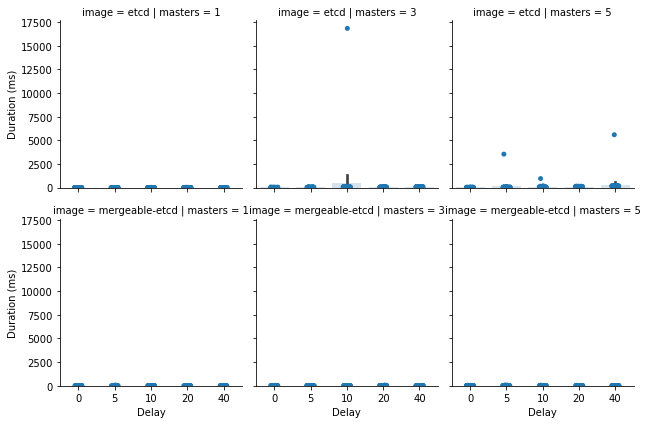

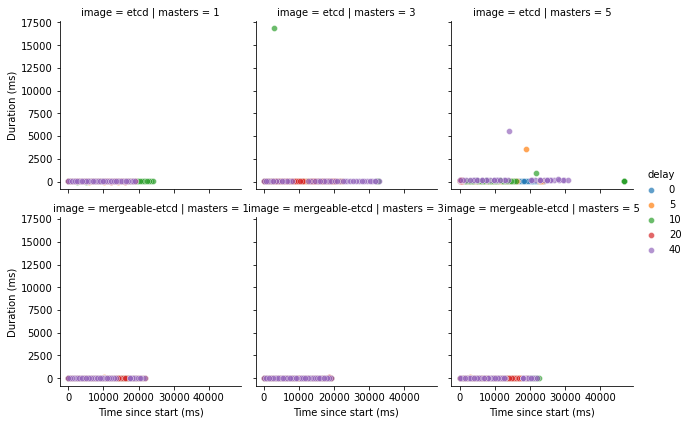

In [51]:
# time for scheduler to get watch event, process it and write back
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]
stripbar(data, "scheduling_time")

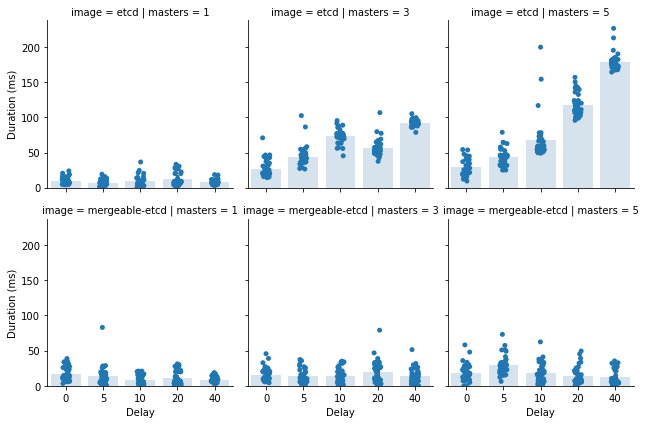

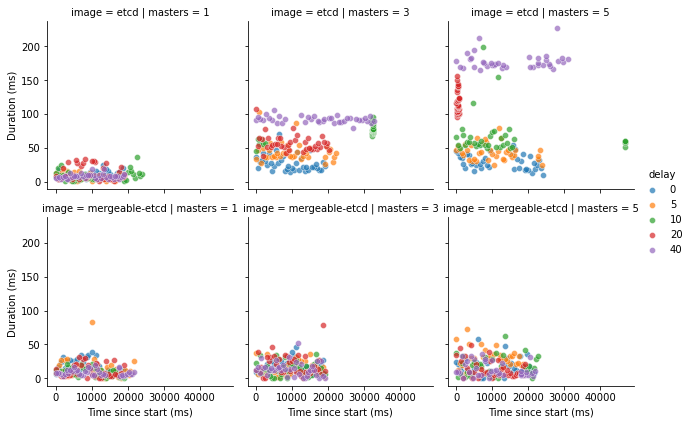

In [52]:
# time for scheduler to get watch event, process it and write back
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]
data = data[data.measurement < 500] # cut off outliers
stripbar(data, "scheduling_time_500")

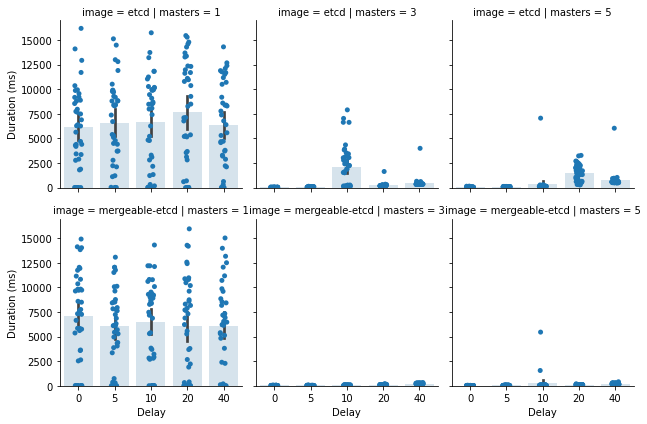

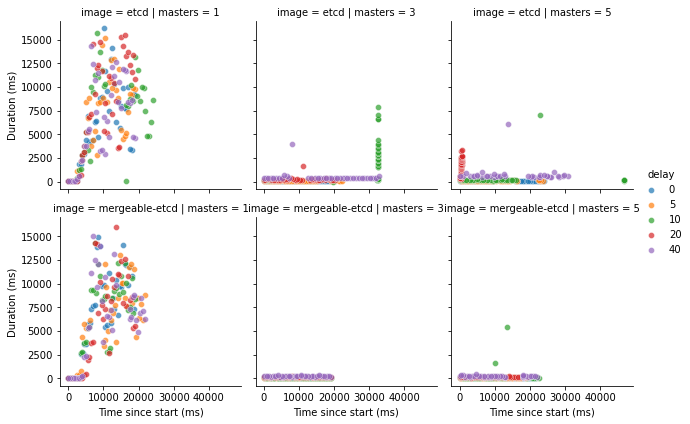

In [53]:
# time for watch to be sent to kubelet and picked up
data = df[np.isin(df.metric, ["client_schedule_to_client_started"])]
stripbar(data, "kubelet_pickup")

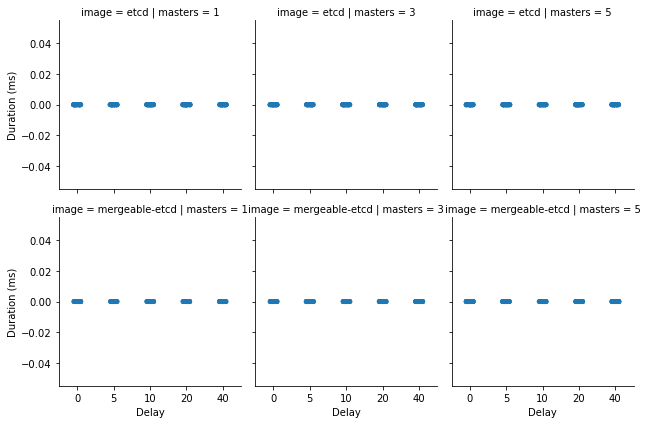

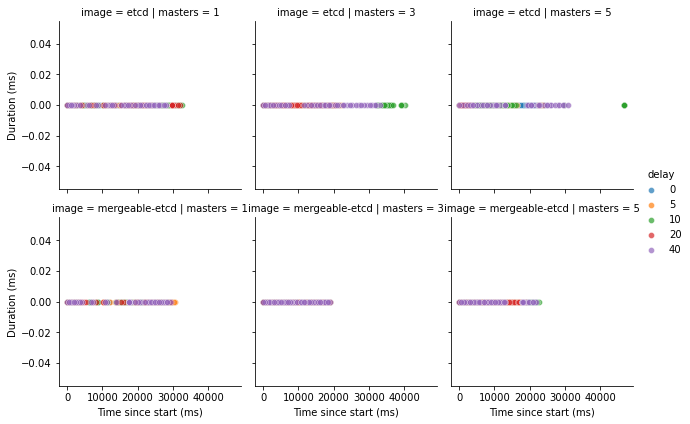

In [54]:
data = df[np.isin(df.metric, ["client_started_to_client_initialized"])]
stripbar(data, "initialize")

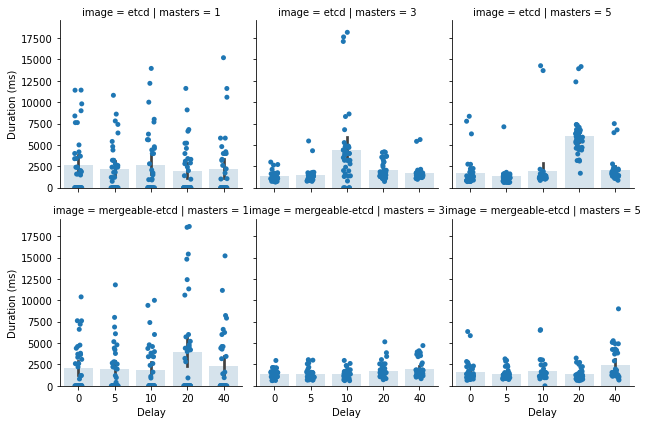

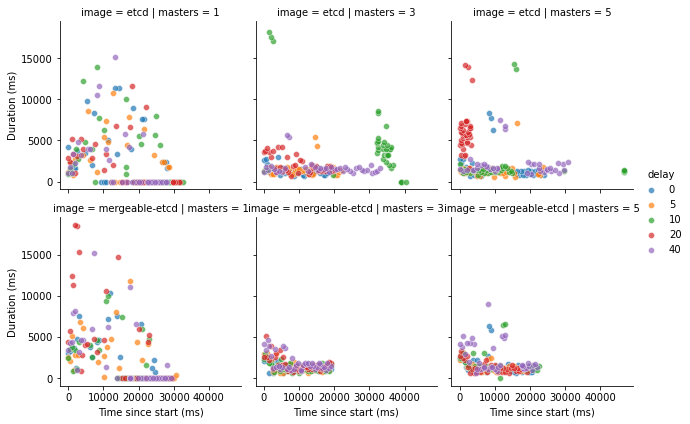

In [55]:
data = df[np.isin(df.metric, ["client_initialized_to_client_containersready"])]
stripbar(data, "container_start")

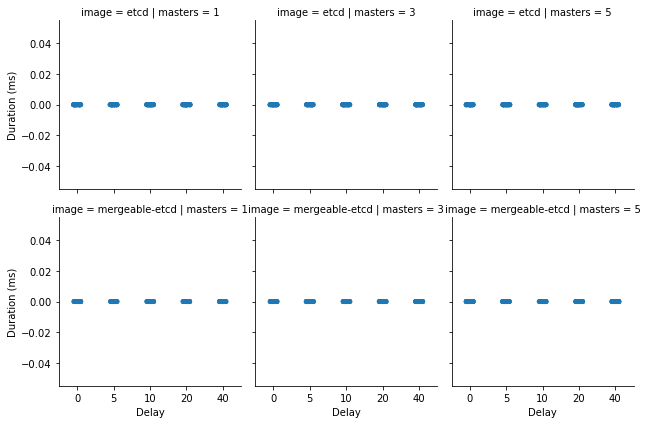

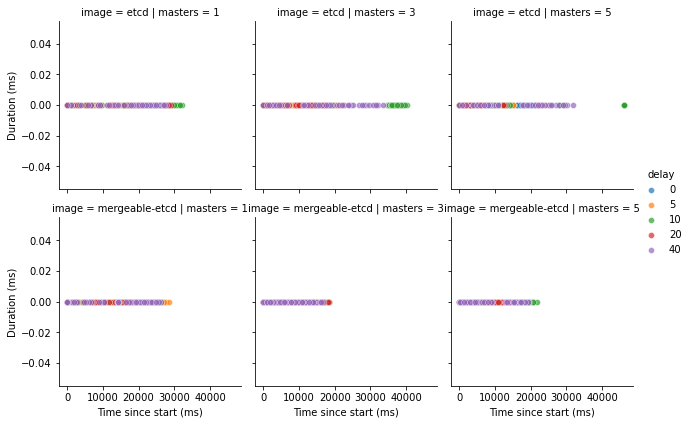

In [56]:
data = df[np.isin(df.metric, ["client_containersready_to_client_podready"])]
stripbar(data, "pod_ready")